In [325]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

In [326]:
#Lietura do DataFrame
df = pd.read_csv('C:/Users/rmuni/Projeto - Algoritmos de Inteligência Artificial para classificação/archive/winequalityN.csv')

In [327]:
# Tratar valores ausentes
for col in df.columns:
    if df[col].dtype == 'object':  # Para colunas categóricas
        df[col].fillna(df[col].mode()[0], inplace=True)  # Preenche com a moda
    else:  # Para colunas numéricas
        df[col].fillna(df[col].median(), inplace=True)  # Preenche com a mediana

C:\Users\rmuni\AppData\Local\Temp\ipykernel_60152\4248037879.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)  # Preenche com a moda
C:\Users\rmuni\AppData\Local\Temp\ipykernel_60152\4248037879.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [328]:
#Criação da variável 'opinion'
df['opinion'] = (df['quality'] > 5).astype(int)

In [329]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,opinion
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.216246,0.339630,0.318718,5.443574,0.056039,30.525319,115.744574,0.994697,3.218384,0.531202,10.491801,5.818378,0.633061
std,1.295779,0.164557,0.145231,4.757585,0.035031,17.749400,56.521855,0.002999,0.160637,0.148769,1.192712,0.873255,0.482007
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


In [330]:
# Separar os DataFrames
df_branco = df[df['type'] == 'white'].copy()  # Filtra apenas vinhos brancos
df_tinto = df[df['type'] == 'red'].copy()  # Filtra apenas vinhos tintos

# Remover a coluna 'type', pois não será mais necessária após a separação
df_branco.drop(columns=['type'], inplace=True)
df_tinto.drop(columns=['type'], inplace=True)

Modelo de Regressão Logística

In [331]:
# Separar features e target
X = df_branco.drop(columns=['opinion','quality'])
y = df_branco['opinion']


In [332]:
# Identificar colunas numéricas e categóricas
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

In [333]:
# Pipeline para transformar os dados
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),  # Normaliza as variáveis numéricas
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)  # Codifica variáveis categóricas
])

In [334]:
# Criar pipeline de modelo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

In [335]:
# Validação cruzada estratificada (k=10)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [336]:
# Definir métricas personalizadas
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

In [337]:
# Avaliação do modelo usando cross_val_score
cv_results = {metric: cross_val_score(model, X, y, cv=cv, scoring=scoring[metric]) for metric in scoring}

In [338]:
# Calcular média e desvio padrão para cada métrica
metrics_summary = {metric: (np.mean(scores), np.std(scores)) for metric, scores in cv_results.items()}

In [339]:
# Exibir resultados
for metric, (mean, std) in metrics_summary.items():
    print(f"{metric}: Média = {mean:.4f}, Desvio Padrão = {std:.4f}")

accuracy: Média = 0.7491, Desvio Padrão = 0.0165
precision: Média = 0.7749, Desvio Padrão = 0.0155
recall: Média = 0.8784, Desvio Padrão = 0.0181
f1: Média = 0.8232, Desvio Padrão = 0.0111


Modelo de Árvores de Decisão

In [340]:
# Criar pipeline de modelo
model_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(criterion='gini', random_state=42))
])

In [341]:
cv_tree = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [342]:
# Definir métricas personalizadas
scoring_tree = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

In [343]:
# Avaliação do modelo usando cross_val_score
cv_results_tree = {metric: cross_val_score(model_tree, X, y, cv=cv_tree, scoring=scoring_tree[metric]) for metric in scoring}

In [344]:
# Calcular média e desvio padrão para cada métrica
metrics_summary_tree = {metric: (np.mean(scores), np.std(scores)) for metric, scores in cv_results_tree.items()}

In [345]:
# Exibir resultados
for metric, (mean, std) in metrics_summary_tree.items():
    print(f"{metric}: Média = {mean:.4f}, Desvio Padrão = {std:.4f}")

accuracy: Média = 0.7958, Desvio Padrão = 0.0194
precision: Média = 0.8501, Desvio Padrão = 0.0174
recall: Média = 0.8419, Desvio Padrão = 0.0234
f1: Média = 0.8457, Desvio Padrão = 0.0152


Modelo SVM

In [346]:
model_SVM = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', C=1.0, random_state=42))
])

In [347]:
cv_SVM = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [348]:
# Definir métricas personalizadas
scoring_SVM = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

In [349]:
# Avaliação do modelo usando cross_val_score
cv_results_SVM = {metric: cross_val_score(model_SVM, X, y, cv=cv_SVM, scoring=scoring_SVM[metric]) for metric in scoring}


In [350]:
# Calcular média e desvio padrão para cada métrica
metrics_summary_SVM = {metric: (np.mean(scores), np.std(scores)) for metric, scores in cv_results_SVM.items()}

In [351]:
# Exibir resultados
for metric, (mean, std) in metrics_summary.items():
    print(f"{metric}: Média = {mean:.4f}, Desvio Padrão = {std:.4f}")

accuracy: Média = 0.7491, Desvio Padrão = 0.0165
precision: Média = 0.7749, Desvio Padrão = 0.0155
recall: Média = 0.8784, Desvio Padrão = 0.0181
f1: Média = 0.8232, Desvio Padrão = 0.0111


 Qual o modelo deveria ser escolhido para uma eventual operação?

In [352]:
# Lista de Modelos
models = {
    'Regressão Logística': LogisticRegression(solver='liblinear', random_state=42),
    'Árvore de Decisão': DecisionTreeClassifier(criterion='gini', random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)  # Ativar probabilidade para curva ROC
}

In [353]:
# Validação cruzada estratificada (k=10)
cv_models = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

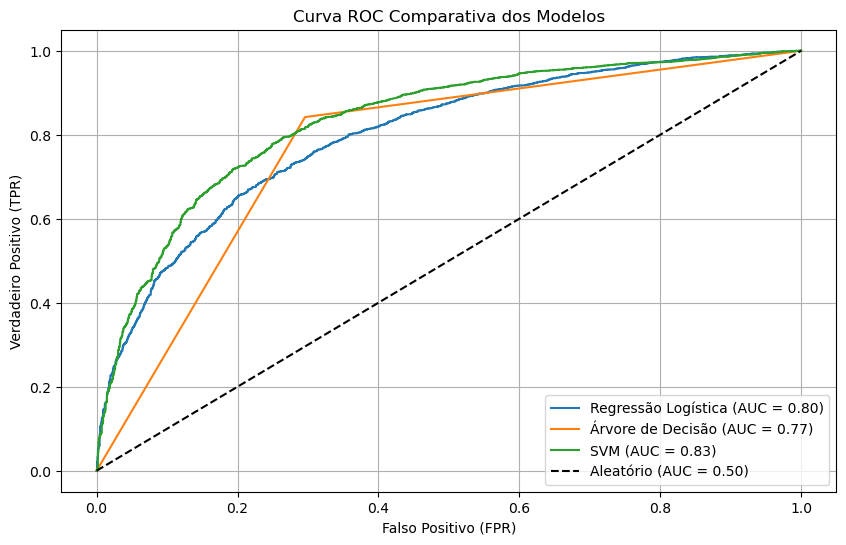

In [354]:
# Plotando a Curva ROC para cada modelo
plt.figure(figsize=(10, 6))

for name, model in models.items():
    # Criar pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Obter probabilidades preditas via validação cruzada
    y_scores = cross_val_predict(pipeline, X, y, cv=cv_models, method="predict_proba")[:, 1]
    
    # Calcular Curva ROC
    fpr, tpr, _ = roc_curve(y, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plotar a Curva ROC
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Adicionar linha de referência (classificador aleatório)
plt.plot([0, 1], [0, 1], 'k--', label="Aleatório (AUC = 0.50)")

# Configuração do gráfico
plt.xlabel("Falso Positivo (FPR)")
plt.ylabel("Verdadeiro Positivo (TPR)")
plt.title("Curva ROC Comparativa dos Modelos")
plt.legend()
plt.grid()
plt.show()

Diante do gráfico comparativo o modelo com melhor AUC-ROC é o SVM com AUC = 0.83, portanto o melhor modelo para ser implementado em produção.

Validando o modelo SVM com df_tinto

In [355]:
# Separar features e target
X_tinto = df_tinto.drop(columns=['opinion','quality'])
y_tinto = df_tinto['opinion'] # Apenas para comparação posterior

In [356]:
preprocessor.fit(X)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index([], dtype='object'))])

In [357]:
#Separando validação e teste
X_train, X_test, y_train, y_test = train_test_split(X, y , random_state = 1)

In [358]:
model_SVM.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index([], dtype='object'))])),
                ('classifier', SVC(random_state=42))])

In [362]:
# Identificar colunas numéricas e categóricas
num_cols = X_tinto.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X_tinto.select_dtypes(include=['object']).columns

In [363]:
# Pipeline para transformar os dados
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),  # Normaliza as variáveis numéricas
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)  # Codifica variáveis categóricas
])

In [364]:
# Fazer a inferência (previsão) com o modelo treinado
y_pred_tinto = model_SVM.predict(X_tinto)  # 'best_model' é o SVM treinado anteriormente

In [365]:
# Contar quantos vinhos foram classificados como bons ou ruins
n_bons = (y_pred_tinto == 1).sum()
n_ruins = (y_pred_tinto == 0).sum()

print(f"Vinhos tintos classificados como bons: {n_bons}")
print(f"Vinhos tintos classificados como ruins: {n_ruins}")

Vinhos tintos classificados como bons: 207
Vinhos tintos classificados como ruins: 1392


In [366]:
accuracy_tinto = accuracy_score(y_tinto, y_pred_tinto)
print(f"Acurácia do modelo nos vinhos tintos: {accuracy_tinto:.4f}")

Acurácia do modelo nos vinhos tintos: 0.5297


O modelo teve uma queda de acurácia, pois as features tem impactos diferentes nas notas dos vinhos dependendo do tipo de vinho.